In [27]:
from typing import List,TypedDict
import re

import pypdf
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS

from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START,END
from pydantic import BaseModel
from dotenv import load_dotenv
load_dotenv()

True

In [28]:
docs = (
    PyPDFLoader('../documents/oops.pdf').load()
)

### Chunk

In [ ]:
chunks = RecursiveCharacterTextSplitter(chunk_size=800,chunk_overlap=100).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode('utf-8','ignore').decode('utf-8','ignore')

In [30]:
len(chunks)

76

### Embedding

In [31]:
embeddings = GoogleGenerativeAIEmbeddings(model='gemini-embedding-001')
vector_stores = FAISS.from_documents(chunks,embeddings)

### Retriever

In [32]:
retriever = vector_stores.as_retriever(search_type="similarity",search_kwargs={"k":2})

### LLM

In [33]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')

### Threshold

In [65]:
UPPER_TH = 0.7
LOWER_TH = 0.3

## State

In [82]:
class State(TypedDict):

    question: str
    docs : List[Document]

    good_docs : List[Document]
    verdict : str
    reason : str

    strips: List[str]
    kept_strips : List[str]

    refined_context : str

    answer : str


### Retriever Node

In [83]:
def retrieve_node(state: State):
    q = state['question']
    return {'docs': retriever.invoke(q)}

### Score Based Doc Evaluation

In [84]:
class DocEvalScore(BaseModel):
    score : float
    reason : str


doc_eval_prompt = ChatPromptTemplate.from_messages(
    [
        (   
            'system',   
            "You evaluate RAG retrieval.\n"
            "Given a question and ONE chunk, return relevance score [0–1].\n"
            "1 = sufficient to answer, 0 = irrelevant.\n"
            "Be conservative.\n"
            "Return JSON:"
        ),
        ("human", "Question: {question}\n\nchunk: {chunk}")
    ]
)

doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)

def eval_each_doc_node(state: State):

    scores : List[float] = []
    reasons : List[str] = []
    good : List[Document] = []

    for d in state['docs']:

        out = doc_eval_chain.invoke({"question":state['question'],"chunk":d.page_content})

        scores.append(out.score)
        reasons.append(out.reason)

        if out.score > LOWER_TH:
            good.append(d)
    

    # Correct 

    if any( s > UPPER_TH for s in scores):
        return {
            'good_docs' : good,
            'verdict': "CORRECT",
            "reason": f"At least one score is greater then {UPPER_TH}",
        }

    # Incorrect 

    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        return {
            'good_docs': [],
            'verdict': "INCORRECT",
            'reason': f"No one score is greater then {LOWER_TH}"
        }

    # Ambiguous

    return {
        'good_docs': good,
        'verdict': "AMBIGUOUS",
        'reason': f"Mixed Ambiguous"
    }

### Knowledge Refinement


In [85]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]


class KeepOrNot(BaseModel):
    keep : bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Decide if a sentence helps answer the question. Return JSON"
        ),
        ("human", "Q:{question}\nS:{sentence}")
    ]
)

filter_chain = filter_prompt | llm.with_structured_output(KeepOrNot)

def refine(state: State):

    context = "\n\n".join(d.page_content for d in state['good_docs']).strip()

    strips  = decompose_to_sentences(context)
    
    kept_strips : List[str] = []

    for s in strips:
        if filter_chain.invoke({"question":state['question'],"sentence":s}).keep:
            kept_strips.append(s)
    
    refined_context = "\n".join(kept_strips).strip()

    return {
        'strips': strips,
        'kept_strips': kept_strips,
        'refined_context': refined_context,
    }


### Generate Answer


In [86]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are Helpful ML tutor. Answer only using the provided refined bullets.\n"
            "If the bullets are empty or insufficient say: I don't Know based on the provided book"
        ),
        (
            "human","Question: {question}\n\nRefined Context \n {refined_context}"
        )
    ]
)

def generate(state: State):
    q = state['question']
    context = state['refined_context']

    answer = (answer_prompt | llm).invoke({"question": q,"refined_context": context})

    return {'answer': answer.content}

In [87]:
def fail_node(state: State):
    return {'answer': f"FAIL: {state['reason']}"}

def ambiguous_node(state: State):
    return {'answer': f"Ambiguous: {state['reason']}"}

def route_after_eval(state: State):

    if state['verdict'] == "CORRECT":
        return "refine"
    elif state['verdict'] == 'INCORRECT':
        return "fail_node"
    
    else:
        return "ambiguous_node"

## Graph Build

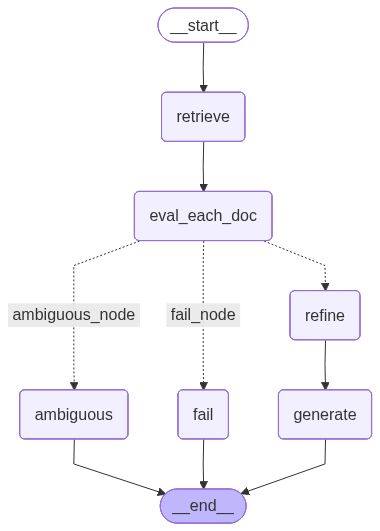

In [88]:
g = StateGraph(State)
g.add_node('retrieve',retrieve_node)
g.add_node('eval_each_doc',eval_each_doc_node)
g.add_node('refine',refine)
g.add_node('generate',generate)
g.add_node('fail',fail_node)
g.add_node('ambiguous',ambiguous_node)


g.add_edge(START,'retrieve')
g.add_edge('retrieve','eval_each_doc')

g.add_conditional_edges(
    'eval_each_doc',
    route_after_eval,
    {'refine': 'refine',"fail_node":"fail","ambiguous_node":"ambiguous"}
)

g.add_edge('refine','generate')
g.add_edge("generate",END)
g.add_edge("fail",END)
g.add_edge("ambiguous",END)

app = g.compile()

app

In [89]:
res = app.invoke({"question": "What is opps"})

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash-lite' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 52.443635781s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '52s'}]}}